In [8]:
import torch
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

from torchlight import import_class

In [9]:
data_path = r'D:\HaAnh\AimCLR-v2-main\data_cobot_clr_zoom\xsub\train_position.npy'
label_path = r'D:\HaAnh\AimCLR-v2-main\data_cobot_clr_zoom\xsub\train_label.pkl'

data_val = np.load(data_path, mmap_mode='r')
with open(label_path, 'rb') as f:
    sample_names, labels_val = pickle.load(f)
labels_val = np.array(labels_val)

In [10]:
import sys
sys.path.append(r'D:\HaAnh\AimCLR-v2-main\net')

In [11]:
model_path = r'D:\HaAnh\AimCLR-v2-main\trial4_fixconfig_512\linear\best_model.pt'

model_class = import_class('net.aimclr_v2_3views_2.AimCLR_v2_3views')
model_args = {
    'base_encoder': 'net.ddnet.DDNet_Original',
    'pretrain': False,
    'class_num': 19,
    'frame_l': 60,
    'joint_d': 3,
    'joint_n': 48,
    'filters': 16,
    'last_feture_dim': 512,
    'feat_d': 1128

}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model_class(**model_args)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model = model.to(device)
model.eval()

AimCLR_v2_3views(
  (encoder_q): DDNet_Original(
    (jcd_conv1): Sequential(
      (0): c1D(
        (conv1): Conv1d(1128, 32, kernel_size=(1,), stride=(1,), bias=False)
        (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): spatialDropout1D(
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
    (jcd_conv2): Sequential(
      (0): c1D(
        (conv1): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): spatialDropout1D(
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
    (jcd_conv3): c1D(
      (conv1): Conv1d(16, 16, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (jcd_pool): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [27]:
features_list = []
batch_size = 32
with torch.no_grad():
    for i in range(0, len(labels_val), batch_size):
        batch_data = data_val[i:i+batch_size]
        batch_tensor = torch.from_numpy(batch_data).float().to(device)
        batch_features = model(None, batch_tensor, stream='all')  # three-stream fusion
        features_list.append(batch_features.cpu().numpy())

features = np.concatenate(features_list, axis=0)
print(f"Features shape: {features.shape}")


C:\Users\Nguyen Ha Anh\AppData\Roaming\Python\Python312\site-packages\torch\nn\functional.py:1542: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


Features shape: (1481, 19)


In [28]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)
print("t-SNE done. Shape:", features_2d.shape)


t-SNE done. Shape: (1481, 2)


In [29]:

n_clusters = 19
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features)
nmi_score = normalized_mutual_info_score(labels_val, cluster_labels)
print(f"NMI Score: {nmi_score:.4f}")


NMI Score: 0.5960


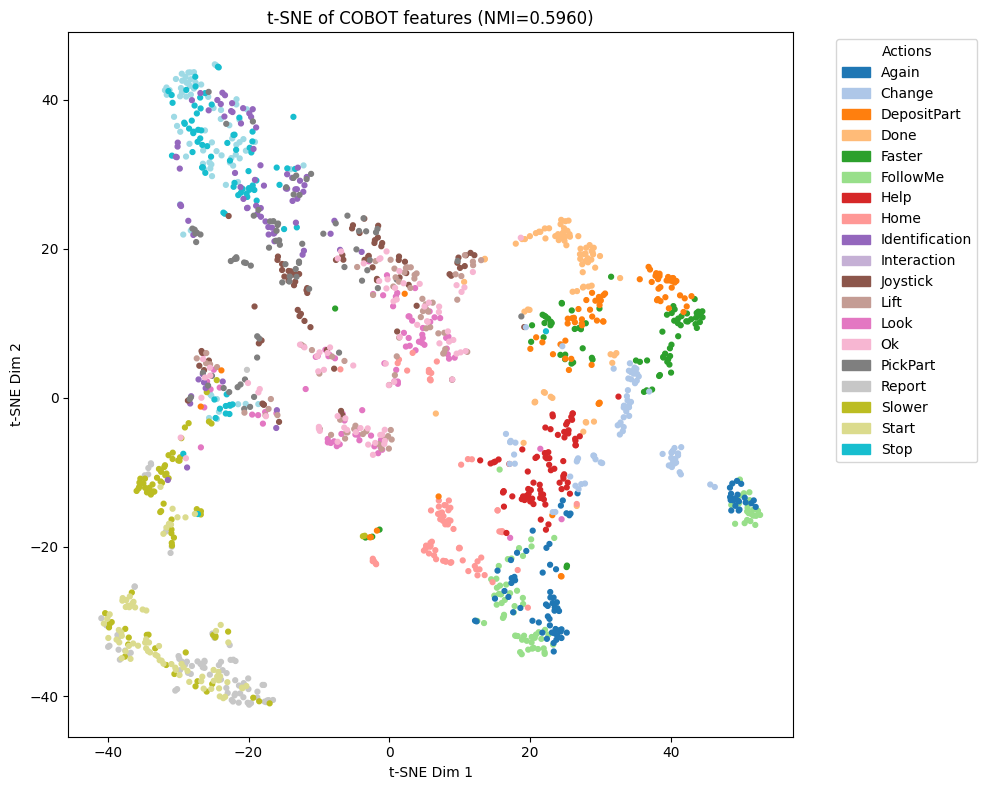

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Action names (the same order như labels_val)
action_names = [
    'Again', 'Change', 'DepositPart', 'Done', 'Faster', 'FollowMe',
    'Help', 'Home', 'Identification', 'Interaction', 'Joystick',
    'Lift', 'Look', 'Ok', 'PickPart', 'Report', 'Slower', 'Start', 'Stop'
]

plt.figure(figsize=(10,8))

# Scatter plot
scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels_val, cmap='tab20', s=12)

# Create legend manually
handles = []
for i, name in enumerate(action_names):
    handles.append(mpatches.Patch(color=plt.cm.tab20(i/19), label=name))
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Actions")

plt.title(f"t-SNE of COBOT features (NMI={nmi_score:.4f})")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.show()


In [13]:
import time
batch_size = 1
times = []

# Warm-up 10 bước (GPU ổn định)
with torch.no_grad():
    for i in range(0, len(labels_val), batch_size):
        batch_data = data_val[i:i+batch_size]
        batch_tensor = torch.from_numpy(batch_data).float().to(device)
        batch_features = model(None, batch_tensor, stream='all') 
        if device == 'cuda':
            torch.cuda.synchronize()

# Timed loop
with torch.no_grad():
    for i in range(0, len(labels_val), batch_size):
        batch_data = data_val[i:i+batch_size]
        batch_tensor = torch.from_numpy(batch_data).float().to(device)
        start = time.time()
        batch_features = model(None, batch_tensor, stream='all') 
        if device == 'cuda':
            torch.cuda.synchronize()
        end = time.time()
        
        times.append(end - start)

# Tính trung bình inference time per sample
avg_time_ms = np.mean(times) * 1000
print(f"Average inference time per sample: {avg_time_ms:.2f} ms")


C:\Users\Nguyen Ha Anh\AppData\Roaming\Python\Python312\site-packages\torch\nn\functional.py:1542: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


AcceleratorError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
